In [1]:
import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(800_000_000_000) ## 800GB?

from calitp.tables import tbl
from calitp import query_sql, magics
import calitp.magics
import branca

import shared_utils

from siuba import *
import pandas as pd

import datetime as dt
import time
from zoneinfo import ZoneInfo

import importlib

import gcsfs
fs = gcsfs.GCSFileSystem()

from tqdm import tqdm_notebook
from tqdm.notebook import trange, tqdm

from IPython.display import display, Markdown


/opt/conda/lib/python3.10/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/google/auth/_default.py:79: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/opt/conda/lib/python3.10/site-packages/google/auth/_default.py:79: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. Yo

In [2]:
import utils

In [3]:
bbb = 300
st = 290

In [4]:
pd.set_option("display.max_columns", 100)


In [5]:
rt_sched = query_sql(
    """
SELECT *
FROM `cal-itp-data-infra-staging.natalie_views.gtfs_rt_vs_sched_routes`
"""
)

/opt/conda/lib/python3.10/site-packages/google/auth/_default.py:79: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/


In [6]:
rt_sched.head()

,calitp_itp_id,agency_name,calitp_url_number,route_id,route_short_name,service_date,num_sched,num_vp,pct_w_vp
0,290,SamTrans,1,17,17,2022-06-07,39,39,1.0
1,290,SamTrans,1,17,17,2022-06-01,35,35,1.0
2,290,SamTrans,1,17,17,2022-06-28,35,35,1.0
3,290,SamTrans,1,110,110,2022-06-24,50,30,0.6
4,290,SamTrans,1,110,110,2022-06-03,53,53,1.0


In [7]:
rt_sched.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5170 entries, 0 to 5169
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   calitp_itp_id      5170 non-null   int64  
 1   agency_name        3514 non-null   object 
 2   calitp_url_number  5170 non-null   int64  
 3   route_id           5170 non-null   object 
 4   route_short_name   5170 non-null   object 
 5   service_date       5170 non-null   object 
 6   num_sched          5170 non-null   int64  
 7   num_vp             5170 non-null   int64  
 8   pct_w_vp           5170 non-null   float64
dtypes: float64(1), int64(4), object(4)
memory usage: 363.6+ KB


In [8]:
rt_sched['service_date'] = pd.to_datetime(rt_sched['service_date'])

In [9]:
rt_sched['weekday'] = pd.Series(rt_sched.service_date).dt.day_name()

In [10]:
rt_sched['month'] =  pd.Series(rt_sched.service_date).dt.month_name()

In [11]:
rt_sched.sample()

,calitp_itp_id,agency_name,calitp_url_number,route_id,route_short_name,service_date,num_sched,num_vp,pct_w_vp,weekday,month
2175,290,None,0,294-196,294,2022-06-17,24,0,0.0,Friday,June


In [12]:
rt_sched.agency_name.value_counts()

SamTrans        3015
Big Blue Bus     499
Name: agency_name, dtype: int64

## Charting

In [13]:
import altair as alt
from dla_utils import _dla_utils

from shared_utils import altair_utils
from shared_utils import geography_utils
from shared_utils import calitp_color_palette as cp
from shared_utils import styleguide

import seaborn as sns


In [14]:
rt_sched.sample()

,calitp_itp_id,agency_name,calitp_url_number,route_id,route_short_name,service_date,num_sched,num_vp,pct_w_vp,weekday,month
142,290,SamTrans,1,130,130,2022-06-01,141,141,1.00,Wednesday,June


In [15]:
rt_sched>>count(_.month)

,month,n
0,June,5170


In [16]:
rt_sched>>group_by(_.agency_name, _.month)>>summarize(avg = _.pct_w_vp.mean())

,agency_name,month,avg
0,Big Blue Bus,June,0.86
1,SamTrans,June,0.79


In [17]:
#aggregating by date
day_pct = utils.agg_by_date(rt_sched, 'num_sched', 'num_vp')

In [18]:
day_pct

,calitp_itp_id,agency_name,calitp_url_number,service_date,weekday,month,total_num_sched,total_num_vp,pct_w_vp
0,290,SamTrans,1,2022-06-01,Wednesday,June,3056,2990,0.98
1,290,SamTrans,1,2022-06-02,Thursday,June,3029,2928,0.97
2,290,SamTrans,1,2022-06-03,Friday,June,3027,2925,0.97
3,290,SamTrans,1,2022-06-04,Saturday,June,1566,1123,0.72
4,290,SamTrans,1,2022-06-05,Sunday,June,1268,943,0.74
5,290,SamTrans,1,2022-06-06,Monday,June,2884,2153,0.75
6,290,SamTrans,1,2022-06-07,Tuesday,June,3273,3176,0.97
7,290,SamTrans,1,2022-06-08,Wednesday,June,2904,1437,0.49
8,290,SamTrans,1,2022-06-09,Thursday,June,2963,1829,0.62
9,290,SamTrans,1,2022-06-10,Friday,June,2959,1787,0.60


In [19]:
#see if we have multiple date entries
day_pct>>count(_.service_date)>>arrange(-_.n)

,service_date,n
0,2022-06-01,2
1,2022-06-02,2
2,2022-06-03,2
3,2022-06-04,2
4,2022-06-05,2
5,2022-06-06,2
6,2022-06-07,2
7,2022-06-08,2
8,2022-06-09,2
9,2022-06-10,2


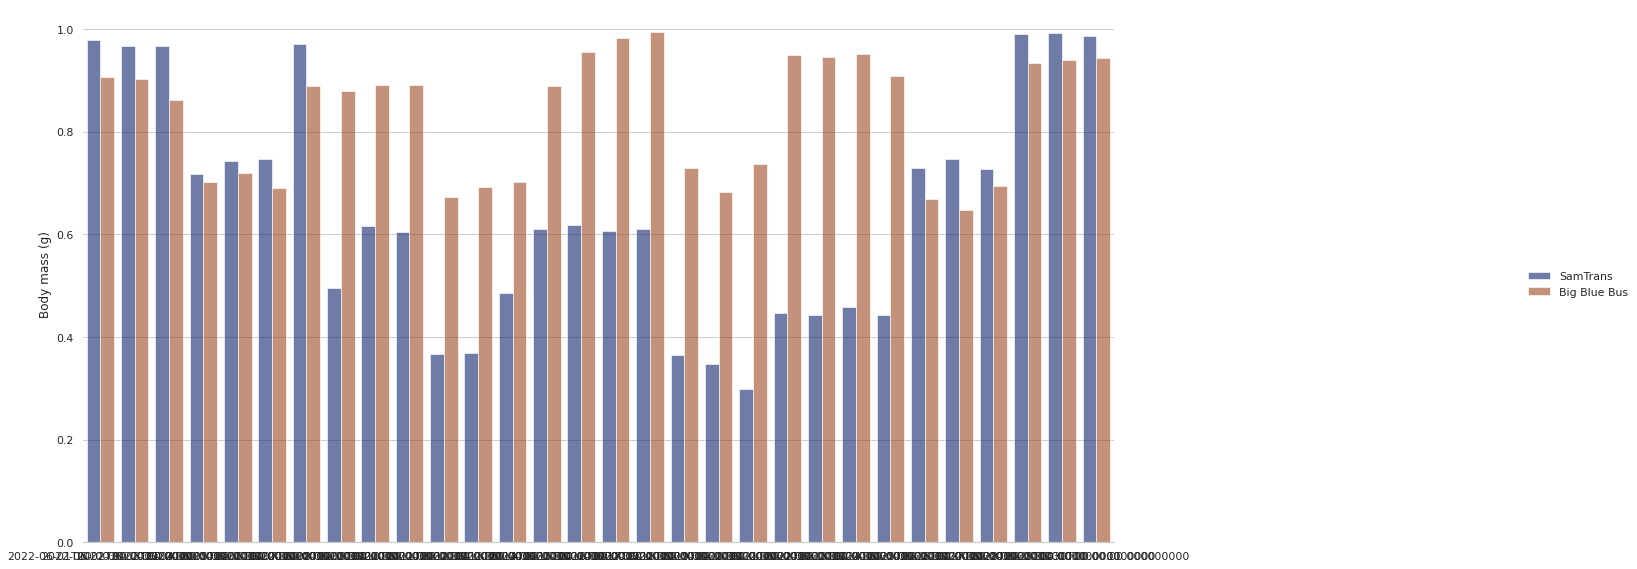

In [20]:
sns.set_theme(style="whitegrid")
g = sns.catplot(
    data=day_pct, kind="bar",
    x="service_date", y="pct_w_vp", hue="agency_name",
    ci="sd", palette="dark", alpha=.6
)
g.fig.set_size_inches(30,9)
g.despine(left=True)
g.set_axis_labels("", "Body mass (g)")
g.legend.set_title("")


In [21]:
bar = (alt.Chart(day_pct>>filter(_.calitp_itp_id==bbb))
        .mark_bar(size=8)
        .encode(
            x=alt.X('service_date', title=utils.labeling('service_date'), sort=("x")),
            y=alt.Y('pct_w_vp:Q', title=utils.labeling('pct_w_vp'), axis=alt.Axis(format='%')),
            color=alt.Color(
                'pct_w_vp',
                scale=alt.Scale(range=altair_utils.CALITP_SEQUENTIAL_COLORS),
                legend=alt.Legend(title=(utils.labeling('pct_w_vp')), symbolLimit=10)
            )
        ).properties(title='Big Blue Bus Percent of Scheduled Trips with RT Vehicle Position Data'))
    
chart = styleguide.preset_chart_config(bar)
chart.properties(width=800)

alt.Chart(...)

In [22]:
bar = (alt.Chart(day_pct>>filter(_.calitp_itp_id==bbb))
        .mark_bar(size=8)
        .encode(
            x=alt.X('service_date', title=utils.labeling('service_date'), sort=("x")),
            y=alt.Y('pct_w_vp', title=utils.labeling('pct_w_vp')),
            color=alt.Color(
                'weekday',
                scale=alt.Scale(range=altair_utils.CALITP_DIVERGING_COLORS),
                legend=alt.Legend(title=(utils.labeling('pct_w_vp'))))
        ).properties(title=" Big Blue Bus Percent of Scheduled Trips with RT Vehicle Position Data"))

# # mean line
rule = alt.Chart(rt_sched>>filter(_.calitp_itp_id==bbb)).mark_rule(color='red').encode(
    y=alt.Y('mean(pct_w_vp):Q', axis=alt.Axis(format='%'))
)

# line = alt.Chart(day_pct).mark_line(
#     color='red',
#     size=2
# ).transform_window(
#     rolling_mean='mean(pct_w_vp)',
#     frame=[-7, 7]
# ).encode(
#     x='service_date:T',
#     y='rolling_mean:Q'
# )

(bar + rule).properties(width=900)

alt.LayerChart(...)

In [23]:
day_pct.sample()

,calitp_itp_id,agency_name,calitp_url_number,service_date,weekday,month,total_num_sched,total_num_vp,pct_w_vp
14,290,SamTrans,1,2022-06-15,Wednesday,June,2990,1846,0.62


In [24]:
df_long =  (day_pct>>select(_.agency_name,
                            _.service_date,
                         _.total_num_sched,
                         _.total_num_vp
                        ) 
             >> gather('measure',
                       'value',
                       _.total_num_sched,
                       _.total_num_vp
                      )
            )

In [25]:
df_long

,agency_name,service_date,measure,value
0,SamTrans,2022-06-01,total_num_sched,3056
1,SamTrans,2022-06-02,total_num_sched,3029
2,SamTrans,2022-06-03,total_num_sched,3027
3,SamTrans,2022-06-04,total_num_sched,1566
4,SamTrans,2022-06-05,total_num_sched,1268
...,...,...,...,...
115,Big Blue Bus,2022-06-26,total_num_vp,500
116,Big Blue Bus,2022-06-27,total_num_vp,1017
117,Big Blue Bus,2022-06-28,total_num_vp,1457
118,Big Blue Bus,2022-06-29,total_num_vp,1454


In [26]:
bar = (alt.Chart(df_long>>filter(_.agency_name == ('Big Blue Bus'))).mark_bar(opacity=1, size=5)
       .mark_bar(size=9)
       .encode(
    x=alt.X('service_date', title=_dla_utils.labeling('service_date'), axis=alt.Axis(format='%b, %Y')),
    y=alt.Y('value', stack=None,  title=_dla_utils.labeling('number of trips')),
    color="measure")
      ).properties(title=" Big Blue Bus Scheduled Trips with RT Vehicle Position Data")

chart = styleguide.preset_chart_config(bar)
chart.properties(width=900)

alt.Chart(...)

In [27]:
day_pct.sample()

,calitp_itp_id,agency_name,calitp_url_number,service_date,weekday,month,total_num_sched,total_num_vp,pct_w_vp
57,300,Big Blue Bus,0,2022-06-28,Tuesday,June,1559,1457,0.93


In [28]:
week = (day_pct>>filter(_.calitp_itp_id==bbb))>>group_by(_.weekday)>>summarize(avg_pct_w_vp = _.pct_w_vp.mean())

In [29]:
week

,weekday,avg_pct_w_vp
0,Friday,0.91
1,Monday,0.71
2,Saturday,0.69
3,Sunday,0.69
4,Thursday,0.93
5,Tuesday,0.92
6,Wednesday,0.93


In [30]:
cats_day = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
week['weekday'] = pd.Categorical(week['weekday'], categories=cats_day, ordered=True)
week=week.sort_values('weekday')          

In [31]:
week

,weekday,avg_pct_w_vp
1,Monday,0.71
5,Tuesday,0.92
6,Wednesday,0.93
4,Thursday,0.93
0,Friday,0.91
2,Saturday,0.69
3,Sunday,0.69


In [32]:
bar = alt.Chart(week).mark_bar().encode(
    x=alt.X('weekday', title=utils.labeling('weekday'), sort=cats_day),
    y=alt.Y('avg_pct_w_vp:Q', title=utils.labeling('avg_pct_w_vp'), axis=alt.Axis(format='%')),
    color=alt.Color(
                'weekday',
                scale=alt.Scale(range=altair_utils.CALITP_DIVERGING_COLORS))
    ).properties(title=" Big Blue Bus Percent of Scheduled Trips with RT Vehicle Position Data by Day")
chart = styleguide.preset_chart_config(bar)
chart

alt.Chart(...)

In [33]:
week_month = ((day_pct>>filter(_.calitp_itp_id==bbb))
    >>group_by(_.month, _.weekday)
    >>summarize(avg_pct_w_vp = _.pct_w_vp.mean()))

In [34]:
week_month.sample()

,month,weekday,avg_pct_w_vp
0,June,Friday,0.91


In [35]:
bar = alt.Chart(week_month).mark_bar().encode(
    x=alt.X('weekday', title=utils.labeling('weekday'), sort=cats_day),
    y=alt.Y('avg_pct_w_vp:Q', title=utils.labeling('avg_pct_w_vp'), axis=alt.Axis(format='%')),
        color=alt.Color(
                'weekday',
                scale=alt.Scale(range=altair_utils.CALITP_DIVERGING_COLORS)),
    column="month").properties(title="Average Big Blue Bus Percent of Scheduled Trips with RT Vehicle Position Data by Day")
chart = styleguide.preset_chart_config(bar)
chart

alt.Chart(...)

In [36]:
cats_month = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

In [37]:
bar = alt.Chart(week_month).mark_bar().encode(
    y=alt.Y('weekday', title=utils.labeling('weekday'), sort=cats_day),
    x=alt.X('avg_pct_w_vp:Q', title=utils.labeling('avg_pct_w_vp'), axis=alt.Axis(format='%')),
        color=alt.Color(
                'weekday',
                scale=alt.Scale(range=altair_utils.CALITP_DIVERGING_COLORS)),
    row=alt.Row("month", sort=cats_month)
    ).properties(title=" Average Big Blue Bus Percent of Scheduled Trips with RT Vehicle Position Data by Month")
chart = styleguide.preset_chart_config(bar)
chart

alt.Chart(...)

In [38]:
line = alt.Chart(week_month).mark_line().encode(
    x=alt.X('weekday', title=_dla_utils.labeling('weekday'), sort=cats_day),
    y=alt.Y('avg_pct_w_vp:Q', title=_dla_utils.labeling('avg_pct_w_vp'), axis=alt.Axis(format='%')),
        color=alt.Color(
                'month',
                scale=alt.Scale(range=altair_utils.CALITP_DIVERGING_COLORS)),
    strokeDash='month',
).properties(title=" Average Big Blue Bus Percent of Scheduled Trips with RT Vehicle Position Data by Month")
line_chart = styleguide.preset_chart_config(line)
line_chart.properties(width=600)

alt.Chart(...)

In [39]:
day_pct>>filter(_.pct_w_vp>.95)

,calitp_itp_id,agency_name,calitp_url_number,service_date,weekday,month,total_num_sched,total_num_vp,pct_w_vp
0,290,SamTrans,1,2022-06-01,Wednesday,June,3056,2990,0.98
1,290,SamTrans,1,2022-06-02,Thursday,June,3029,2928,0.97
2,290,SamTrans,1,2022-06-03,Friday,June,3027,2925,0.97
6,290,SamTrans,1,2022-06-07,Tuesday,June,3273,3176,0.97
27,290,SamTrans,1,2022-06-28,Tuesday,June,2634,2607,0.99
28,290,SamTrans,1,2022-06-29,Wednesday,June,2606,2588,0.99
29,290,SamTrans,1,2022-06-30,Thursday,June,2635,2600,0.99
44,300,Big Blue Bus,0,2022-06-15,Wednesday,June,1505,1437,0.95
45,300,Big Blue Bus,0,2022-06-16,Thursday,June,1514,1487,0.98
46,300,Big Blue Bus,0,2022-06-17,Friday,June,1516,1507,0.99


In [40]:
day_pct>>filter(_.service_date >= '2022-06-01', _.service_date <= '2022-06-03')>>arrange(_.service_date)

,calitp_itp_id,agency_name,calitp_url_number,service_date,weekday,month,total_num_sched,total_num_vp,pct_w_vp
0,290,SamTrans,1,2022-06-01,Wednesday,June,3056,2990,0.98
30,300,Big Blue Bus,0,2022-06-01,Wednesday,June,1613,1463,0.91
1,290,SamTrans,1,2022-06-02,Thursday,June,3029,2928,0.97
31,300,Big Blue Bus,0,2022-06-02,Thursday,June,1614,1458,0.90
2,290,SamTrans,1,2022-06-03,Friday,June,3027,2925,0.97
32,300,Big Blue Bus,0,2022-06-03,Friday,June,1609,1387,0.86


## Group By Month

In [41]:
utils.groupby_twocol(day_pct, 'agency_name', 'month', 'pct_w_vp', 'month')

,agency_name,month,avg
0,Big Blue Bus,June,0.83
1,SamTrans,June,0.65


In [43]:
utils.groupby_onecol((day_pct>>filter(_.agency_name==('Big Blue Bus'))), 'month', 'pct_w_vp')

,month,avg
0,June,0.83


In [47]:
bar = alt.Chart(utils.groupby_twocol(day_pct, 'agency_name', 'month', 'pct_w_vp', 'month')).mark_bar().encode(
    x=alt.X('month', title=utils.labeling('month'), sort=cats_month),
    y=alt.Y('avg:Q', title=utils.labeling('pct_w_vp'), axis=alt.Axis(format='%')),
        color=alt.Color(
                'agency_name',
                scale=alt.Scale(range=altair_utils.CALITP_DIVERGING_COLORS)),
    column = 'agency_name')
chart = styleguide.preset_chart_config(bar)
chart

alt.Chart(...)

## Using Functions (without DBT tables)

In [38]:
#gtfs_daily = utils.load_schedule_data(analysis_date_start, analysis_date_end, itp_id)

In [39]:
#gtfs_daily

In [40]:
#gtfs_daily.service_date.min()

In [41]:
#gtfs_daily.service_date.max()

In [42]:
#rt = utils.load_rt_data(analysis_date_start, analysis_date_end)

In [43]:
#rt

In [44]:
#rt['str_len'] = rt.trip_id.str.len()

In [45]:
#rt.str_len.value_counts()

In [46]:
#len(rt)

In [47]:
#rt.trip_id.nunique()

In [48]:
#len(gtfs_daily)

In [49]:
#gtfs_daily.trip_id.nunique()

In [50]:
#date_list =['2022-05-01','2022-05-02', '2022-05-31']

In [51]:

# from datetime import date, timedelta
# start_date = date(2022, 5, 1)
# end_date = date(2022, 5, 31)

In [52]:
# daterange = pd.date_range(start_date, end_date)

In [53]:
# (daterange)

In [54]:
#above range does not work with function

In [55]:
# dates = set()

# def daterange2(start, end):
#     for n in range(int((end - start).days) + 1):
#         yield start + timedelta(n)

# for single_date in daterange2(start_date, end_date):
#     dates.add(single_date.strftime('%Y-%m-%d'))

In [56]:
# (dates)

In [57]:
# rt['date'] = pd.to_datetime(rt['date'])

In [58]:
# gtfs_daily['service_date'] = pd.to_datetime(gtfs_daily['service_date'])

In [59]:
# single_date2 = '2022-05-08'

# (rt>>filter(_.date == single_date2))


In [60]:
# def get_pct_ran_df2(itp_id, list_of_dates):
#     pcts = []
#     for single_date in list_of_dates:
#         gtfs_daily2 = (gtfs_daily>>filter(_.service_date == single_date))
#         rt2 = (rt>>filter(_.date == single_date))
#         sched_rt_df = (pd.merge(gtfs_daily2, rt2, how='outer', on='trip_id', indicator='have_rt'))
#         #pct_ran = (utils.get_pct_ran(sched_rt_df, single_date))
#         day_pct_ran = {}
#         day_pct_ran['date'] = single_date
#         if ((len(sched_rt_df))!=0):
#             day_pct_ran['pct_trips_ran'] = ((len(sched_rt_df>>filter(_.have_rt=='both')))/(len(gtfs_daily2)))
#         elif ((len(sched_rt_df))==0):
#             day_pct_ran['pct_trips_ran'] = ''
#         pct_ran = pd.DataFrame([day_pct_ran])
#         pct_ran['n_have_rt'] = (len(sched_rt_df>>filter(_.have_rt=='both')))
#         pct_ran['n_missing_rt'] = (len(sched_rt_df>>filter(_.have_rt=='right_only')))
#         pct_ran['unmatched_rt'] = (len(sched_rt_df>>filter(_.have_rt=='left_only')))
#         pct_ran['nunique_sched'] = (gtfs_daily2.trip_id.nunique())
#         pct_ran['nunique_rt'] = (rt2.trip_id.nunique())

#         pcts.append(pct_ran)                                                    
#         #code help from: https://stackoverflow.com/questions/28669482/appending-pandas-dataframes-generated-in-a-for-loop
#     pcts = pd.concat(pcts)
#     pcts = pcts>>arrange(_.date)
#     return pd.DataFrame(pcts)


In [61]:
# may = utils.get_pct_ran_df(itp_id, dates, gtfs_daily, rt)

In [62]:
# may